In [271]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [273]:
netflix_df = pd.read_csv('netflix_data.csv')
netflix_df.head()

,title,type,genres,releaseYear,imdbId,imdbAverageRating,imdbNumVotes,availableCountries
0,Ariel,movie,"Comedy, Crime, Romance",1988.0,tt0094675,7.4,9065.0,NaN
1,Shadows in Paradise,movie,"Comedy, Drama, Music",1986.0,tt0092149,7.4,7871.0,NaN
2,Forrest Gump,movie,"Drama, Romance",1994.0,tt0109830,8.8,2363068.0,NaN
3,American Beauty,movie,Drama,1999.0,tt0169547,8.3,1244358.0,NaN
4,The Fifth Element,movie,"Action, Adventure, Sci-Fi",1997.0,tt0119116,7.6,524401.0,NaN


In [275]:
netflix_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21216 entries, 0 to 21215
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   title               20522 non-null  object 
 1   type                21216 non-null  object 
 2   genres              20852 non-null  object 
 3   releaseYear         21177 non-null  float64
 4   imdbId              19639 non-null  object 
 5   imdbAverageRating   19454 non-null  float64
 6   imdbNumVotes        19454 non-null  float64
 7   availableCountries  161 non-null    object 
dtypes: float64(3), object(5)
memory usage: 1.3+ MB


In [277]:
netflix_df.describe()

,releaseYear,imdbAverageRating,imdbNumVotes
count,21177.000000,19454.000000,1.945400e+04
mean,2013.304340,6.400879,3.184755e+04
std,14.301382,1.093803,1.213091e+05
min,1913.000000,1.200000,5.000000e+00
25%,2012.000000,5.700000,3.290000e+02
50%,2018.000000,6.500000,1.599500e+03
75%,2022.000000,7.200000,1.016625e+04
max,2025.000000,9.800000,3.022948e+06


In [279]:
netflix_df.isnull().sum()

title                   694
type                      0
genres                  364
releaseYear              39
imdbId                 1577
imdbAverageRating      1762
imdbNumVotes           1762
availableCountries    21055
dtype: int64

In [293]:
# Start cleaning data
# Eliminar filas con título vacío
netflix_df = netflix_df.dropna(subset=['title'])

# Rellenar los valores nulos en 'genres' con 'Unknown'
netflix_df['genres'] = netflix_df['genres'].fillna('Unknown')

# Eliminar filas con valores nulos en 'releaseYear', 'imdbAverageRating', 'imdbNumVotes'
netflix_df = netflix_df.dropna(subset=['releaseYear', 'imdbAverageRating', 'imdbNumVotes'])

# Eliminar filas donde 'releaseYear' es nulo (por si queda algún valor NaN)
netflix_df = netflix_df.dropna(subset=['releaseYear'])

# Convertir 'releaseYear' a entero
netflix_df['releaseYear'] = netflix_df['releaseYear'].astype(int)

# Rellenar los valores nulos en 'availableCountries' con 'Unknown'
netflix_df['availableCountries'] = netflix_df['availableCountries'].fillna('Unknown')

In [295]:
netflix_df.isnull().sum()

title                 0
type                  0
genres                0
releaseYear           0
imdbId                0
imdbAverageRating     0
imdbNumVotes          0
availableCountries    0
dtype: int64

In [297]:
# Guardar el dataset limpio
netflix_df.to_csv('netflix_data_cleaned.csv', index=False)

In [299]:
# Ver las primeras filas del dataset
print(netflix_df.head())

# Ver el tamaño del dataset (filas, columnas)
print(netflix_df.shape)

# Ver el tipo de datos de cada columna
print(netflix_df.dtypes)

                 title   type                     genres  releaseYear  \
0                Ariel  movie     Comedy, Crime, Romance         1988   
1  Shadows in Paradise  movie       Comedy, Drama, Music         1986   
2         Forrest Gump  movie             Drama, Romance         1994   
3      American Beauty  movie                      Drama         1999   
4    The Fifth Element  movie  Action, Adventure, Sci-Fi         1997   

      imdbId  imdbAverageRating  imdbNumVotes availableCountries  
0  tt0094675                7.4        9065.0            Unknown  
1  tt0092149                7.4        7871.0            Unknown  
2  tt0109830                8.8     2363068.0            Unknown  
3  tt0169547                8.3     1244358.0            Unknown  
4  tt0119116                7.6      524401.0            Unknown  
(19454, 8)
title                  object
type                   object
genres                 object
releaseYear             int64
imdbId                 objec

In [301]:
# Estadísticas descriptivas de las columnas numéricas
print(netflix_df.describe())

        releaseYear  imdbAverageRating  imdbNumVotes
count  19454.000000       19454.000000  1.945400e+04
mean    2012.904390           6.400879  3.184755e+04
std       14.644126           1.093803  1.213091e+05
min     1913.000000           1.200000  5.000000e+00
25%     2011.000000           5.700000  3.290000e+02
50%     2018.000000           6.500000  1.599500e+03
75%     2021.000000           7.200000  1.016625e+04
max     2025.000000           9.800000  3.022948e+06


genres
Comedy                          1660
Drama                           1557
Comedy, Drama                    791
Documentary                      757
Drama, Romance                   667
Comedy, Romance                  649
Comedy, Drama, Romance           629
Action, Adventure, Animation     537
Adventure, Animation, Comedy     400
Action, Crime, Drama             386
Name: count, dtype: int64


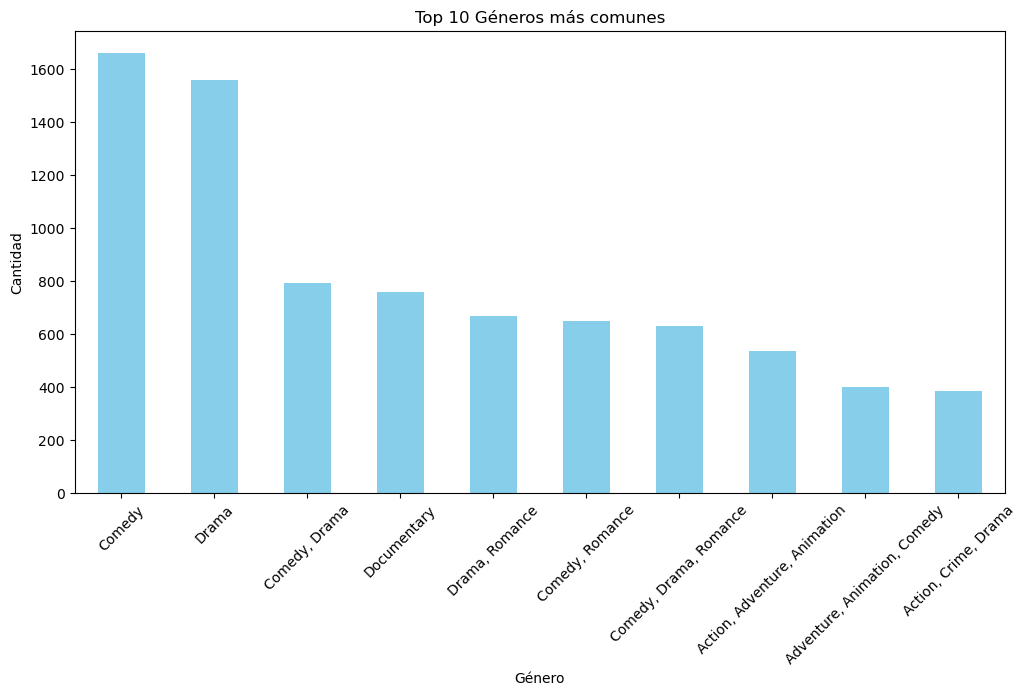

In [305]:
# Contar la cantidad de películas/series por género
genre_counts = netflix_df['genres'].value_counts()

# Mostrar los 10 géneros más comunes
print(genre_counts.head(10))

genre_counts.head(10).plot(kind='bar', figsize=(12,6), color='skyblue')
plt.title('Top 10 Géneros más comunes')
plt.xlabel('Género')
plt.ylabel('Cantidad')
plt.xticks(rotation=45)
plt.show()

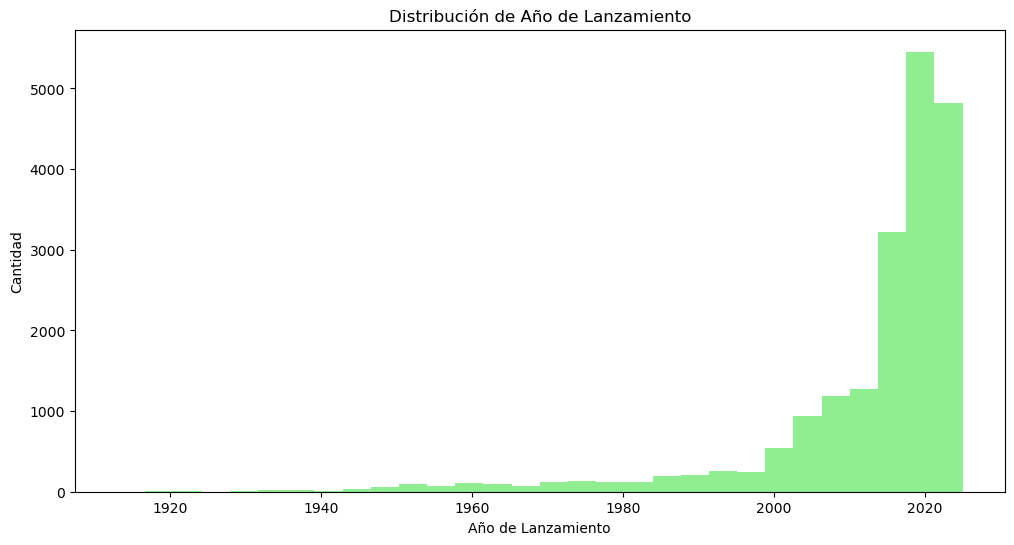

In [307]:
# Histograma de los años de lanzamiento
plt.figure(figsize=(12,6))
netflix_df['releaseYear'].plot(kind='hist', bins=30, color='lightgreen')
plt.title('Distribución de Año de Lanzamiento')
plt.xlabel('Año de Lanzamiento')
plt.ylabel('Cantidad')
plt.show()